<a href="https://colab.research.google.com/github/anapitalai/gee/blob/main/sentinel2_cloud_detector_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentinel Hub's Sentinel-2 Cloud Detector

This example notebook shows how to perform cloud classification and cloud masking on Sentinel-2 data.

In the process we will use [`sentinelhub-py`](https://github.com/sentinel-hub/sentinelhub-py) Python package. The package documentation is available [here](https://sentinelhub-py.readthedocs.io/en/latest/).

In [ ]:
!pip install s2cloudless

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import requests
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import CRS, BBox, DataCollection, MimeType, SentinelHubRequest, SHConfig, generate_evalscript
from sentinelhub.api.catalog import get_available_timestamps

from s2cloudless import S2PixelCloudDetector, download_bands_and_valid_data_mask

### Sentinel Hub credentials

These examples require Sentinel Hub OAuth client credentials. Please check [`sentinelhub-py` configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#sentinel-hub-capabilities) on how to obtain the credentials and configure them in the package.

In [4]:
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = "7e62036e-c7c3-4c12-ad7b-cfb5824e9200"
CLIENT_SECRET = "sewhoLJRjkmngK20b0m8PdNHEsS862ju"


config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

## Download and calculate cloud masks

We'll demonstrate two key parts:

1. download satellite data
2. calculate cloud masks and probabilities from data

We will first show how to do step 1. with the `sentinelhub-py` package (which gives the user more control). Later we'll introduce some utilities of the `s2cloudless` package for downloading data.


### Example scenes: Acatenango and Volcan Fuego (Guatemala) in December 2017

Acatenango area in Guatemala is well known for its coffee plantations. At the altitute of about 2000 m and given it’s climate, it is often veiled in clouds.

First, lets define the bounding box for the area of interest:

In [5]:
bbox = BBox(((725000, 1595000), (735000, 1610000)), crs=CRS("32615"))

### Download Sentinel-2 data

Let's download data using [Sentinel Hub Process API](https://docs.sentinel-hub.com/api/latest/api/process/). The `s2cloudless` detector only requires `10` out of `13` bands for cloud detection, however in this example we will download all Sentinel-2 bands, to have all RBG bands for visualization.

For simplicity we will request data with reflectance values. To decrease download costs a better option is to download data in digital numbers (i.e. unsigned ints) and then rescale them with normalization factors.

In [6]:
data_collection = DataCollection.SENTINEL2_L1C
evalscript = generate_evalscript(
    data_collection=data_collection,
    meta_bands=["dataMask"],
    merged_bands_output="bands",
    prioritize_dn=False,
)

print(evalscript)


//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12", "dataMask"],
            units: ["REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "REFLECTANCE", "DN"]
        }],
        output: [{id: "bands", bands: 13, sampleType: "FLOAT32"}, {id: "dataMask", bands: 1, sampleType: "UINT8"}]
    }
}

function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
    outputMetadata.userData = {
        "norm_factor":  inputMetadata.normalizationFactor
    }
}

function evaluatePixel(sample) {
    return { bands: [sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09, sample.B10, sample.B11, sample.B12], dataMask: [sample.dataMask] };
}



In [7]:
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[SentinelHubRequest.input_data(data_collection=data_collection, time_interval="2017-12-01")],
    responses=[
        SentinelHubRequest.output_response("bands", MimeType.TIFF),
        SentinelHubRequest.output_response("dataMask", MimeType.TIFF),
    ],
    bbox=bbox,
    resolution=(10, 10),
    config=config,
)

data = request.get_data()[0]

bands = data["bands.tif"]
mask = data["dataMask.tif"]

bands.shape, mask.shape

((1500, 1000, 13), (1500, 1000))

### Initialize the cloud detector and make classification

We can specify the following arguments in the initialization of a `S2PixelCloudDetector`:

 * `threshold` - cloud probability threshold value. All pixels with cloud probability above threshold value are masked as cloudy pixels. Default is `0.4`.
 * `average_over` - Size of the disk in pixels for performing convolution (averaging probability over pixels). For this resolution `4` is appropriate.
 * `dilation_size` - Size of the disk in pixels for performing dilation.  For this resolution `2` is appropriate.
 * `all_bands` - Flag specifying that input images will consists of all 13 Sentinel-2 bands. It has to be set to `True` if we would download all bands. If you define a layer that would return only 10 bands, then this parameter should be set to `False`.

In [8]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=4, dilation_size=2, all_bands=True)

#### Run the classification

There are two possibilities:
 * `get_cloud_probability_maps` will return cloud probability map
 * `get_cloud_masks` will return binary cloud masks

In [9]:
%%time
# The cloud detector works on stacks of images, but we have a single image.
# By using `bands[np.newaxis, ...]` we go from 3D to 4D

cloud_prob = cloud_detector.get_cloud_probability_maps(bands[np.newaxis, ...])

CPU times: user 1min 9s, sys: 148 ms, total: 1min 9s
Wall time: 40.3 s


In [10]:
%%time

cloud_mask = cloud_detector.get_cloud_masks(bands[np.newaxis, ...])

CPU times: user 1min 9s, sys: 143 ms, total: 1min 9s
Wall time: 40.3 s


### Visualize the results

We have a binary cloud mask:

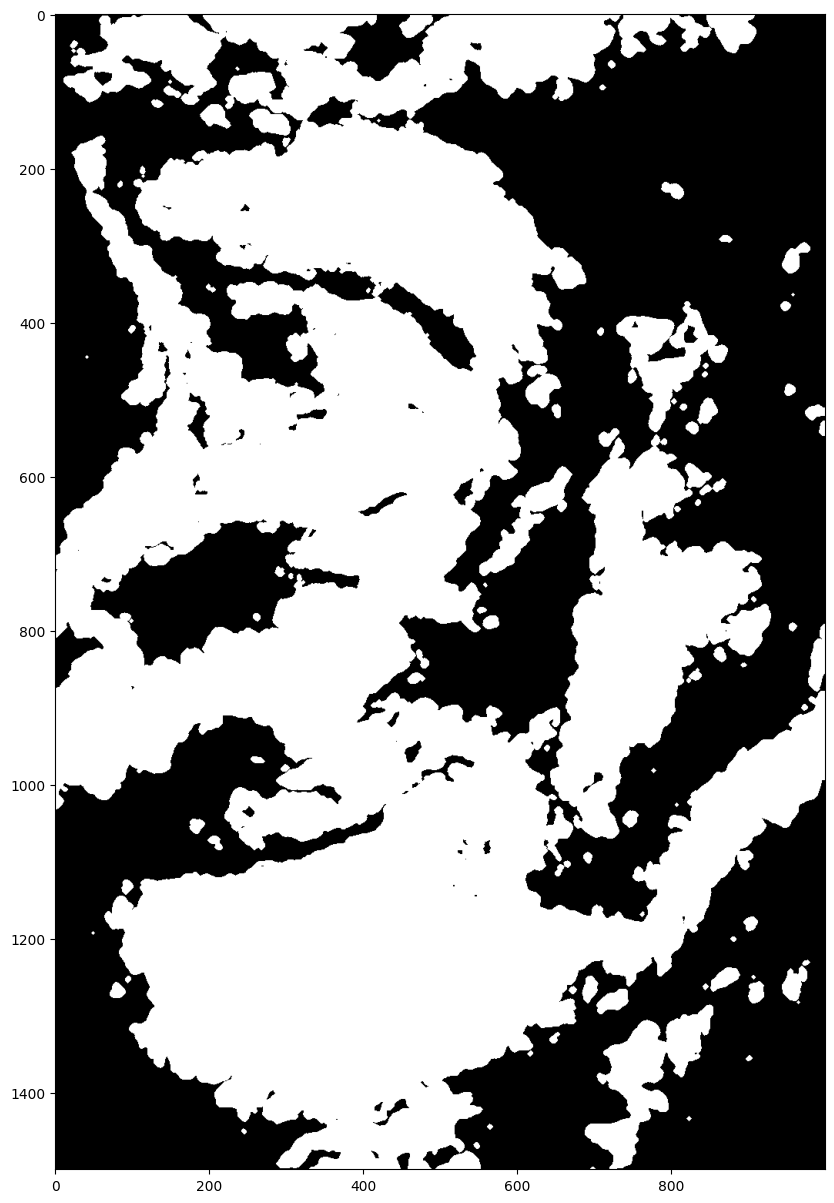

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(cloud_mask[0], cmap=plt.cm.gray)

Let's plot a true color image overlaid with the cloud mask:

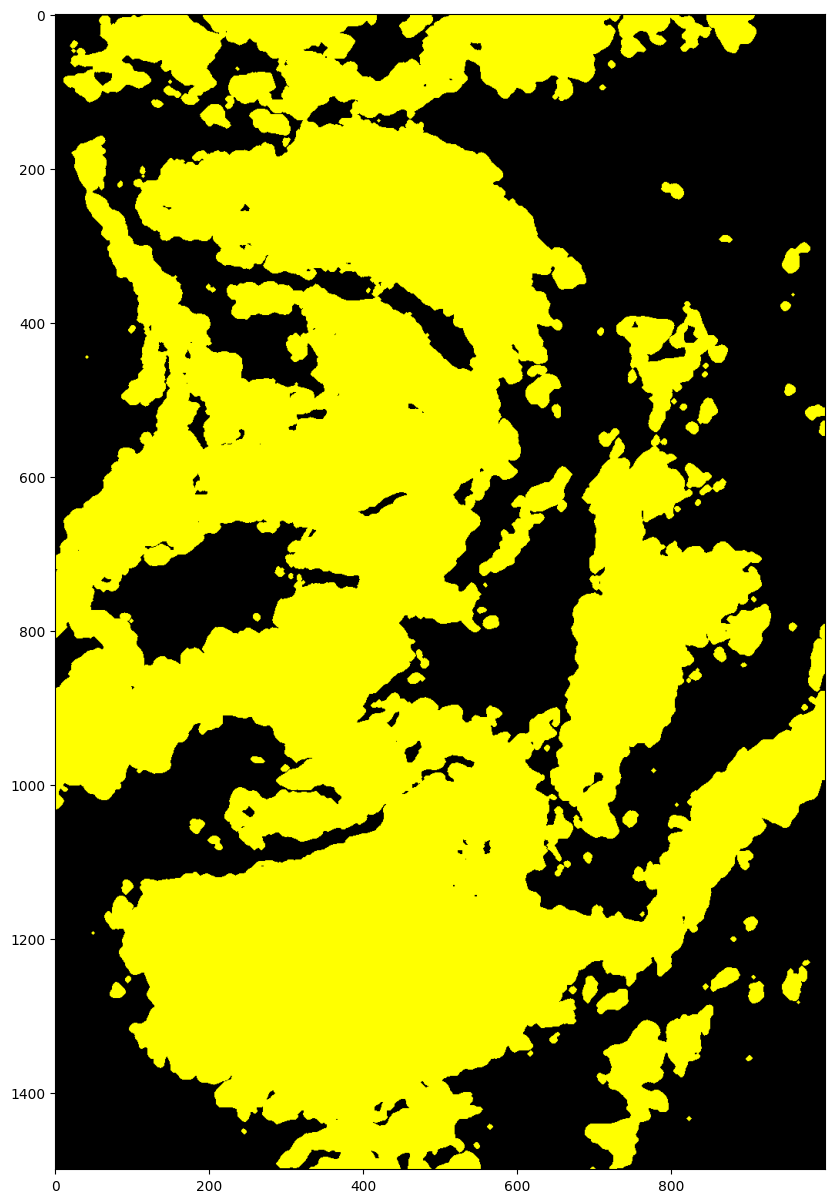

In [12]:
true_color_image = (bands[..., [3, 2, 1]] * 3.5).clip(0, 1)
is_cloud = cloud_mask[0]

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
ax.imshow(true_color_image)
ax.imshow(is_cloud, cmap="gnuplot", alpha=0.3 * is_cloud)

Besides that we also have pseudo-probability scores telling us how likely it is that certain pixel is cloudy:

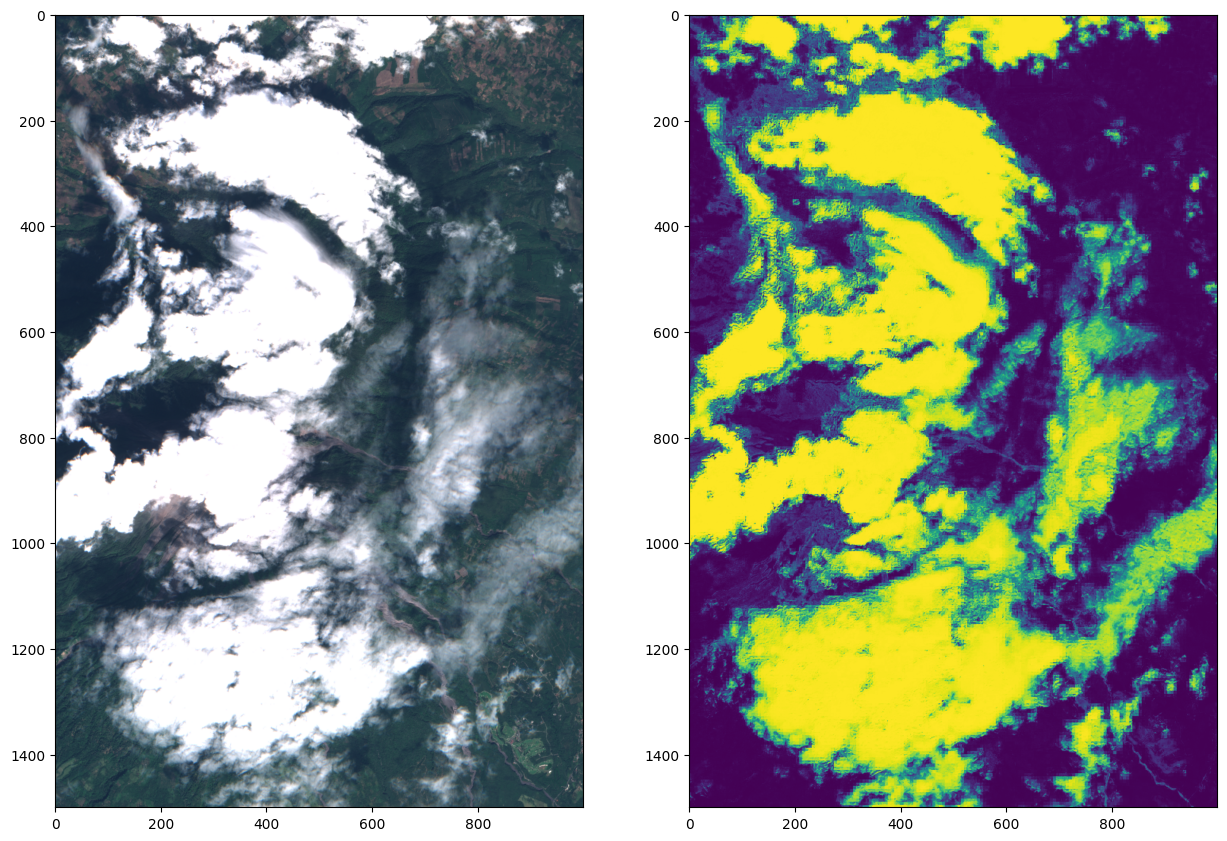

In [13]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(true_color_image)
ax[1].imshow(cloud_prob[0])

## Another way of use

In this part we show:

1. how to use `get_timestamps` to obtain suitable timestamps for an area in the given time interval
2. introduction to `download_bands_and_valid_data_mask` that makes data acquisition easier
3. experimenting with `threshold` in the `get_mask_from_prob` function

The utility `get_timestamps` is an interface to [Sentinel Hub Catalog API](https://docs.sentinel-hub.com/api/latest/api/catalog/) and obtains information on when data is available (for the given criteria).

In [16]:
timestamps = get_available_timestamps(
    data_collection=data_collection, bbox=bbox, time_interval=(dt.datetime(2017, 12, 1), dt.datetime(2017, 12, 12)), config=config
)
timestamps

[datetime.datetime(2017, 12, 1, 16, 38, 51),
 datetime.datetime(2017, 12, 6, 16, 32, 21),
 datetime.datetime(2017, 12, 11, 16, 39, 21)]

We download data for all suitable `timestamps`. The function `download_bands_and_valid_data` automates the process, and also uses digital number + normalization behind the scenes to reduce the costs.

In [18]:
bands, masks = download_bands_and_valid_data_mask(bbox=bbox, resolution=(10, 10), timestamps=timestamps,config=config)

We now repeat cloud cloud-mask calculations on the recieved data. This time we calculate the mask directly from probability maps with the `get_mask_from_prob` method.

In [ ]:
cloud_detector = S2PixelCloudDetector(threshold=0.4, average_over=1, dilation_size=1, all_bands=True)

probability_maps = cloud_detector.get_cloud_probability_maps(bands)
cloud_mask = cloud_detector.get_mask_from_prob(probability_maps)

Let's extract RGB bands:

In [ ]:
true_color_images = np.clip(bands[..., [3, 2, 1]] * 3.5, 0, 1)

Let's plot cloud masks together with images:

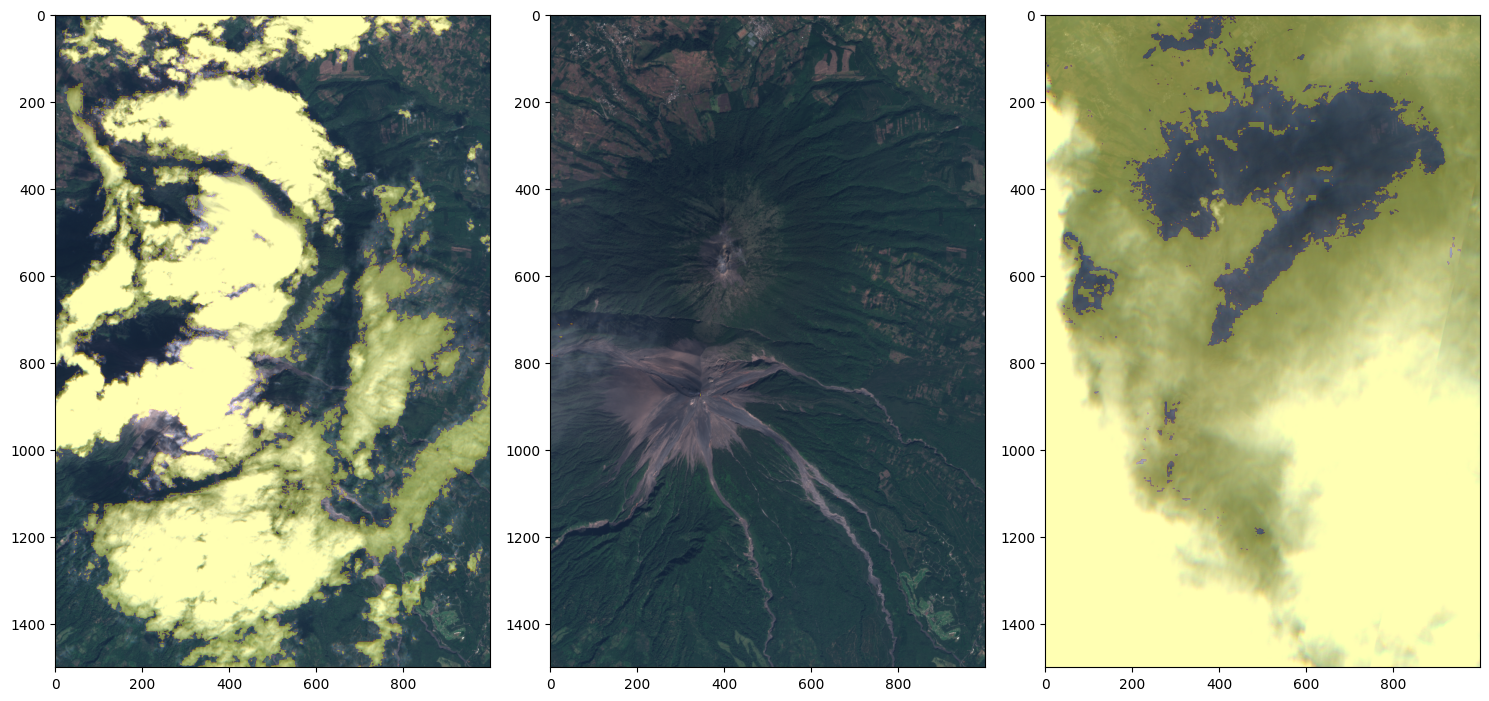

In [ ]:
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, cloud_mask)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    ax.imshow(image)
    ax.imshow(mask, cmap="gnuplot", alpha=0.3 * (mask > 0))

plt.tight_layout()

If the probability threshold of `0.4` doesn't suit us we can recompute cloud masks with a different threshold. Since we're computing masks from probabilities (and not via ML inference) the process is faster.

In [ ]:
cloud_mask_2 = cloud_detector.get_mask_from_prob(probability_maps, threshold=0.2)

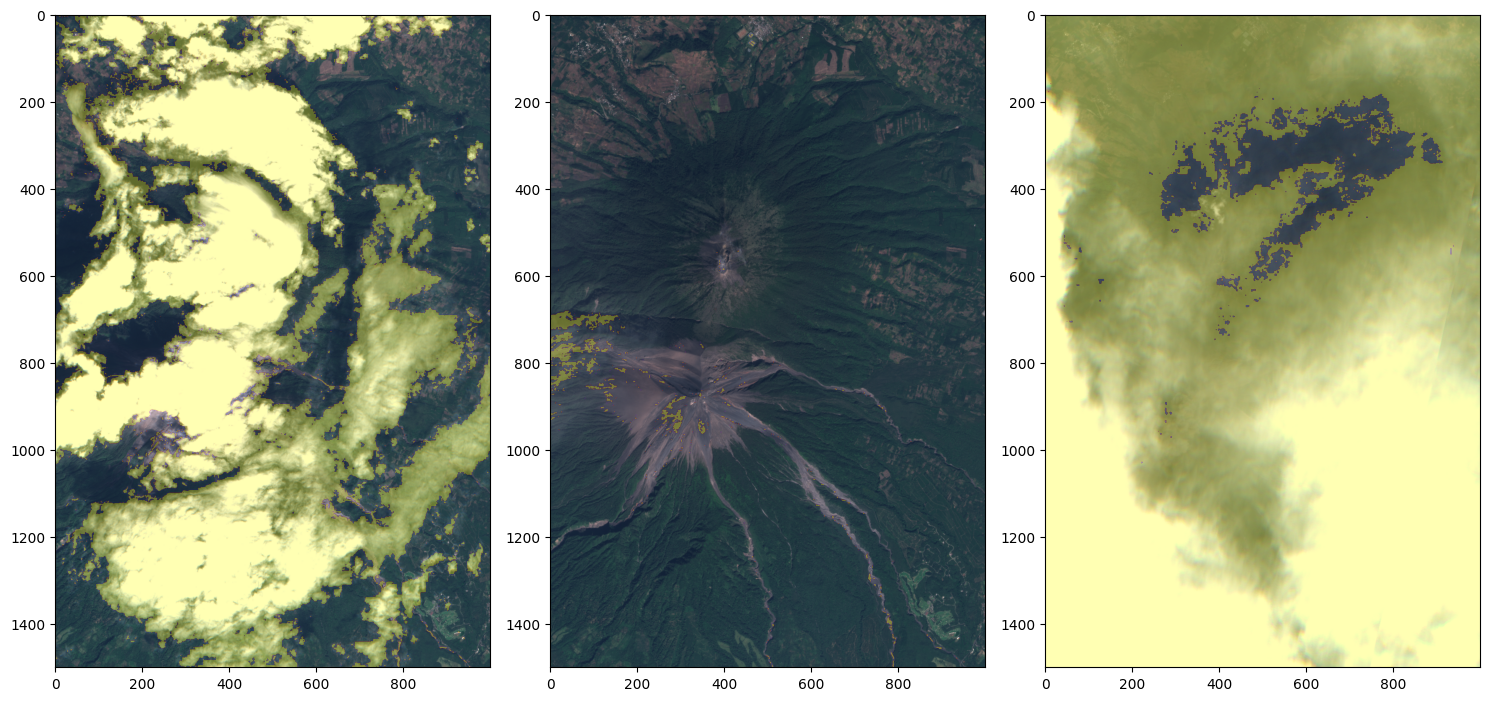

In [ ]:
fig = plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = int(np.ceil(len(true_color_images) / n_cols))

for idx, (image, mask) in enumerate(zip(true_color_images, cloud_mask_2)):
    ax = fig.add_subplot(n_rows, n_cols, idx + 1)
    ax.imshow(image)
    ax.imshow(mask, cmap="gnuplot", alpha=0.3 * (mask > 0))

plt.tight_layout()